In [16]:
import csv
import pandas as pd
import random
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statistics
from sklearn import neighbors
from sklearn.neighbors imporhttp://localhost:8888/notebooks/Urban%20-%20HW1.ipynb#t KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [17]:
data = pd.read_csv("yellow_tripdata_2017-02.csv")
# list first few rows (datapoints)
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-02-03 02:03:50,2017-02-03 02:20:55,1,3.29,1,N,87,246,1,14.0,0.0,0.5,1.50,0.0,0.3,16.30
1,2,2017-02-03 02:26:04,2017-02-03 02:46:47,1,2.80,1,N,68,239,2,15.0,0.0,0.5,0.00,0.0,0.3,15.80
2,2,2017-02-03 02:49:51,2017-02-03 09:56:17,1,0.90,1,N,239,43,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16
3,2,2017-02-03 04:41:54,2017-02-03 04:52:41,1,0.72,1,N,163,230,1,8.0,0.0,0.5,1.76,0.0,0.3,10.56
4,2,2017-02-03 04:57:38,2017-02-03 12:16:14,1,1.10,1,N,186,230,1,11.0,0.0,0.5,3.54,0.0,0.3,15.34


**Randomly sample 10,000 trip records to solve the Problems 2 and 3. Choose specific dataframe columns to do processing.**

In [18]:
dfSample = data.sample(10000)
print(dfSample.shape)
tip = dfSample['tip_amount']
print(type(tip))
fare = dfSample['fare_amount']
timestamp = dfSample['tpep_pickup_datetime']
paytype = dfSample['payment_type']

(10000, 17)
<class 'pandas.core.series.Series'>


**The dataset has several different payment types. Convert the ‘payment_type’ to categorical data: "Payment_type_cat1, Payment_type_cat2, …".**

In [19]:
paytype_num = np.max(paytype)
print(paytype_num)
d = {}
for i in range(1, paytype_num + 1):
	d['payment_type_cat' + str(i)] = [0] * 10000

4


**Create new features by iterating through the whole dataframe. To convert the ‘tpep_pickup_datetime’ to day (for 1) or night (for 0), I just manually set 6:00 to 19:00 as Daytime.**

In [20]:
tip_rate=[]
dayornight = []
count = 0
# https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops?lq=1
for idx, row in dfSample.iterrows():
	tip_rate.append(1 if tip[idx]/fare[idx] > 0.2 else 0)
	for i in range(1, paytype_num + 1):
		if paytype[idx] == i:
			d['payment_type_cat' + str(i)][count] = 1 
	count += 1
	# print(timestamp[idx])
    #      
	dayornight.append(1 if int(timestamp[idx][11:13]) < 19 and int(timestamp[idx][11:13]) >= 6 else 0)

/Users/pujm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


**Assign new columns to dataframe.**

In [21]:
dfSample=dfSample.assign(tip_rate_20 = tip_rate, DayorNight = dayornight)
for i in range(1, paytype_num + 1):
	# print(d['payment_type_cat' + str(i)])
	dfSample['payment_type_cat' + str(i)] = d['payment_type_cat' + str(i)]

**Create a dataset with the following attributes.**

In [22]:
dfP1 = dfSample.filter(items = ['VendorID', 'DayorNight', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 
	'tip_amount','fare_amount', 'tip_rate_20', 'payment_type'])
dfP2 = dfSample.filter(regex = '^payment_type_cat[0-9]$')
# print(dfP2)
frames = [dfP1, dfP2]

result = pd.concat(frames, axis=1)
result.to_csv("processed_trip_data.csv")

**Plot the distribution of the Fare_amounts and Tip_amounts.**

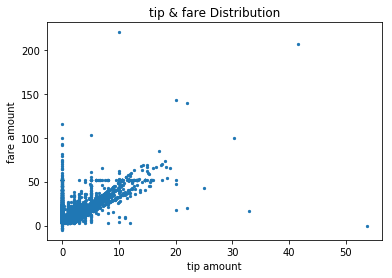

In [23]:
x = tip.values
y = fare.values
plt.scatter(x.tolist(), y.tolist(), s = 5)
plt.xlabel("tip amount")
plt.ylabel("fare amount")
plt.title("tip & fare Distribution")
plt.show()

## Problem 2: Trip fare amount prediction.

**Training dataset preparation.**

In [24]:
data = pd.read_csv("processed_trip_data.csv")

def get_input_matrix(df):
	df1 = df.filter(items = ['DayorNight', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID'])
	df2 = df.filter(regex = '^payment_type_cat[0-9]$')
	print(df1.shape)
	print(df2.shape)
	frames = [df1, df2]
	return pd.concat(frames, axis=1)

def get_output_matrix(df):
	return df['fare_amount']

taxi_X_train = get_input_matrix(data)
taxi_Y_train = get_output_matrix(data)
print(taxi_X_train.shape)
print(taxi_Y_train.shape)

(10000, 5)
(10000, 4)
(10000, 9)
(10000,)


### Linear Regression - MSE Report

In [25]:
lr = linear_model.LinearRegression()

# Here we use cross_val_score for cross validation, set scoring as 'neg_mean_squared_error',
# So that we can obtain scores which are actually negative MSE for each fold.
# By using -np.mean(scores) and np.std(scores), we obtain the averaged MSE and its std for all 5 folds.
scores = cross_val_score(lr, taxi_X_train, taxi_Y_train, scoring = 'neg_mean_squared_error',cv=5)
print("MSE scores for 5 folds: ", [-score for score in scores])
print("Averaged MSE score - [LinearRegression]: ", - np.mean(scores))
std_score = np.std(scores)
print("Standard Deviation of MSE scores for 5 folds - [LinearRegression]:", std_score)

MSE scores for 5 folds:  [26.463124038914071, 13.308088643073297, 36.243227524051257, 21.333198745239482, 8.9987997709235028]
Averaged MSE score - [LinearRegression]:  21.2692877444
Standard Deviation of MSE scores for 5 folds - [LinearRegression]: 9.64514861299


### KNN Regression - MSE Report

In [26]:
# Use a for loop to iterate through k from 1 to 10, 
# choose the k that obtains the minimum MEAN SQUARE ERROR, which indicates the best model.
mse_min = 0; k = 0
for i in range(1, 11):
	neigh = KNeighborsRegressor(n_neighbors=i)
	scores = cross_val_score(neigh, taxi_X_train, taxi_Y_train, scoring = 'neg_mean_squared_error', cv=5)
	mean_score = - np.mean(scores)
	if mse_min == 0 or mse_min > mean_score:
		mse_min = mean_score
		k = i
print("The opitimal K value for the KNN regression model: ", k, ", which obtains minimum mse score: ", mse_min)


neigh = KNeighborsRegressor(n_neighbors=2)
scores = cross_val_score(neigh, taxi_X_train, taxi_Y_train, scoring = 'neg_mean_squared_error', cv=5)
mean_score = - np.mean(scores)
print("Averaged MSE score - [KNN regression]: ", mean_score)
std_score = np.std(scores)
print("Standard Deviation of MSE scores for 5 folds - [KNN regression]:", std_score)

The opitimal K value for the KNN regression model:  2 , which obtains minimum mse score:  29.1698144875
Averaged MSE score - [KNN regression]:  29.1698144875
Standard Deviation of MSE scores for 5 folds - [KNN regression]: 8.49597040327


#### In general, Linear regression works better than KNN regression for this task, because linear regression tends to get lower MSE score than KNN.  For KNN regression, the optimal K value tends to be 2 though I sample different data every time.

## Problem 3. Tip rate classification.

** 1. Sample 1000 trip records from your data, Use KNN model to predict the Tip_rate_20.<br>
Training data preparation. Use attribute b, c, d, h as input features, use attribute k as class labels. **

In [27]:
# Sample 1000 data
data = pd.read_csv("processed_trip_data.csv")
data = data.sample(1000)

# Use attribute b, c, d, h as input features for KNN model
def get_input_matrix_knn(df):
	df1 = df.filter(items = ['DayorNight', 'passenger_count', 'trip_distance'])
	df2 = df.filter(regex = '^payment_type_cat[0-9]$')  
	print(df1.shape)
	print(df2.shape)
	frames = [df1, df2]
	return pd.concat(frames, axis=1)

# Use attribute k as class labels.
def get_output_matrix(df):
	return df['tip_rate_20']

# Build decision tree with attribute b, c, d, g.
def get_input_matrix_dt(df):
	return df.filter(items = ['DayorNight', 'passenger_count', 'payment_type', 'trip_distance'])

**KNN Model:<br>
Use Euclidean distance;<br> 
Run 5-fold cross validation to evaluate your model; <br>
Report precision, recall and F-score of the classification.**

In [28]:
# KNN
taxi_X_train_knn = get_input_matrix_knn(data)
taxi_Y_train = get_output_matrix(data)


Kneigh = KNeighborsClassifier(n_neighbors=5, p=2)
predicted = cross_val_predict(Kneigh, taxi_X_train_knn, taxi_Y_train, cv=5)
print(metrics.classification_report(predicted, taxi_Y_train))

(1000, 3)
(1000, 4)
             precision    recall  f1-score   support

          0       0.68      0.80      0.74       423
          1       0.83      0.72      0.77       577

avg / total       0.77      0.76      0.76      1000



**2. Use Decision Tree to predict the Tip_rate_20.<br>
 For trip distance, calculate the average and use it as the threshold to create conditions --- I set trip_distance as 0 if the trip_distance is less than the average, otherwise as 1.**


In [35]:
# Decision Tree
taxi_X_train_dt = get_input_matrix_dt(data)
# For trip distance, you can calculate the average and use it as the threshold to create conditions.
distMean = taxi_X_train_dt['trip_distance'].mean()
for idx, row in taxi_X_train_dt.iterrows():
	if taxi_X_train_dt['trip_distance'][idx] < distMean:
		taxi_X_train_dt['trip_distance'][idx] = 0
	else:

		taxi_X_train_dt['trip_distance'][idx] = 1

/Users/pujm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/pujm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


**Use 5-fold cross validation to evaluate your model.<br>
Report precision, recall and F-score of the classification.**

In [36]:
decisionTree = DecisionTreeClassifier()

predicted = cross_val_predict(decisionTree, taxi_X_train_dt, taxi_Y_train, cv=5)
print(metrics.classification_report(predicted, taxi_Y_train))

             precision    recall  f1-score   support

          0       0.63      0.95      0.76       334
          1       0.97      0.73      0.83       666

avg / total       0.86      0.80      0.81      1000



### Since we randomly choose samples every time, we may get different metric reports. However, generally for this task, DecisionTreeClassifier gets higher precision and recall than KNN does. KNN gets higher F1-score.